In [17]:
# import library
import numpy as np 
import pandas as pd
import re
import os

import matplotlib.pyplot as plt
%matplotlib inline

import keras
import keras.utils
from sklearn import preprocessing
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten

from functools import partial
from keras import metrics

In [18]:
MAX_SEQUENCES_LENGTH = 50 # Maximum kata pada kalimat
MAX_NB_WORDS = 6000 # Vocabulary size
EMBEDDING_DIM = 50 # Dimensions of Glove word vector kadang bisa juga 100

In [19]:
# open dataset,save on dataframe
df = pd.read_csv("dataset.csv",encoding="ISO-8859-1")

# membuka data slang (data yang akan dibenarkan)
with open('slang.txt') as file:
    slang_map = dict(map(str.strip, line.partition('\t')[::2])
    for line in file if line.strip())
    
df.head()

,created_at,screen_name,text,Label
0,5/1/2021 16:48,theoholan,itu mah konflik rebutan tanah,0
1,5/3/2021 14:12,KoloElang,Bisa tidak? Palestina taat secara kaffah dala...,0
2,5/4/2021 5:55,viktorkonyolsky,Bagaimana mengelola/menghadapi pemberontakan:...,1
3,5/5/2021 10:27,ambiszen,kalo palestina rohingya lebih ke konflik polit...,0
4,5/5/2021 10:54,NephiLaxmus,Teroris 'islam' Itu gejala baru terutama seba...,0


In [20]:
# drop column created_at and screen_name
df = df.drop(['created_at', 'screen_name'], axis=1)

In [21]:
df.head()

,text,Label
0,itu mah konflik rebutan tanah,0
1,Bisa tidak? Palestina taat secara kaffah dala...,0
2,Bagaimana mengelola/menghadapi pemberontakan:...,1
3,kalo palestina rohingya lebih ke konflik polit...,0
4,Teroris 'islam' Itu gejala baru terutama seba...,0


In [22]:
# Pre-Processing dataset
# fungsi case folding dan menghapus RT dan CC
def casefoldingRemoveRt(text):
     # menghapus RT (reetwet)
    text = re.sub(r'^[RT]+', '', text) 
    # case folding (menjadi lower case)
    text = text.lower()
    # menghapus CC (carbon copy)
    text = re.sub(r'^[cc]+', '', text)
    return text

# fungsi untuk menghapus noise
def removeNoise(text): 
    # menghapus unicode
    text = re.sub(r'(\\u[0-9A-Fa-f]+)','', text)
    # menghapus emoticon
    text = re.sub(r'[^\x00-\x7f]','',text)
    # menghapus url
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',text) 
    # menghapus # (biasanya utk menandai topik tertentu)
    text = re.sub(r'#([^\s]+)', '', text) 
    # menghapus "@users"
    text = re.sub('@[^\s]+','',text)
    return text

# mengganti kata2 slang menjadi lebih baku
slang_words = sorted(slang_map, key=len, reverse=True) # longest first for regex
regex = re.compile(r"\b({})\b".format("|".join(map(re.escape, slang_words))))
replaceSlang = partial(regex.sub, lambda m: slang_map[m.group(1)])

def removePunctuation(text): 
    # menghapus integers/numbers
    text = ''.join([i for i in text if not i.isdigit()]) 
    # khusus untuk tanda baca ' (dirapatkan dengan text)
    text = re.sub("'",'',text)
    # menghapus punctuation (tanda baca)
    text = re.sub(r"[^A-Za-z]+"," ",text)
    # menghapus 1 karakter
    text = re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', text)
    # menghapus whitespace
    text = ' '.join(text.split())
    return text

In [23]:
df['text'] = df['text'].apply(lambda x: casefoldingRemoveRt(x))
df['text'] = df['text'].apply(lambda x: removeNoise(x))
df['text'] = df['text'].apply(lambda x: replaceSlang(x))
df['text'] = df['text'].apply(lambda x: removePunctuation(x))

In [24]:
df.head()

,text,Label
0,itu mah konflik rebutan tanah,0
1,bisa tidak palestina taat secara kaffah dalam ...,0
2,bagaimana mengelola menghadapi pemberontakan b...,1
3,kalau palestina rohingya lebih ke konflik poli...,0
4,teroris islam itu gejala baru terutama sebagai...,0


In [25]:
 # Tokenizing
from nltk.tokenize import word_tokenize 

In [26]:
# Lakukan tokenizer terlebih dahulu
stop = pd.read_csv('stopword.txt', sep=" ", header=None)

In [27]:
# Stop Word
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

In [29]:
def stopWord(text):
    stop = stopword.remove(text)
    return stop

df['text'] = df['text'].apply(lambda x: stopWord(x))
df['text']

0                               mah konflik rebutan tanah
1       palestina taat kaffah islam mengganti demokras...
2       mengelola menghadapi pemberontakan berunding m...
3       palestina rohingya konflik politik si oknum te...
4       teroris islam gejala imbas konflik israel pale...
                              ...                        
1541    satukan hati satukan tekad satulan langkah bur...
1542    ngelihatnya gencatan senjata sengaja mengulur ...
1543    bergembira merayakan gencatan senjata israel h...
1544    lucu sih die hard fans konflik israel palestin...
1545             zionis deh langgar gencatan senjata fuck
Name: text, Length: 1546, dtype: object

In [30]:
# delete missing value 
nan_value = float('NaN')
df.replace('', nan_value, inplace=True)
df.dropna(subset=['text'], inplace=True)

0    653
2    524
1    369
Name: Label, dtype: int64


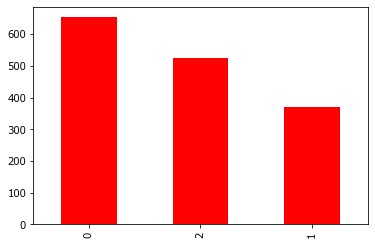

In [31]:
# menghitung Label sentimen (menampilkan tabel pembagian label sentimen)
labels = df.Label
labels_count = labels.value_counts()
labels_count.plot(kind="bar", x='Label', y='Jumlah', color='red')
print(labels.value_counts())

In [109]:
# convert to CSV
#df.to_csv('stopwordste.csv', encoding='utf-8', index=False)

In [32]:
# Prepare to X as Feature
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.text)
sequences = tokenizer.texts_to_sequences(df.text)
# Banyak kata yang telah di tokenizer
word_index = tokenizer.word_index

In [33]:
print('Found %d unique words.' % len(word_index))

Found 4384 unique words.


In [34]:
X = pad_sequences(sequences, maxlen=MAX_SEQUENCES_LENGTH, padding='post')

In [35]:
# Prepare to y as label
y = df["Label"]
y = to_categorical(y)

In [36]:
classes = ['0', '1', '2']

In [62]:
# Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1 random_state=20, stratify=y)

SyntaxError: invalid syntax (Temp/ipykernel_12500/1963518426.py, line 2)

In [49]:
# open Glove
print('Indexing word vectors.')

embeddings_index = {}
f = open(os.path.join('dataset/glove/vectors.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 331286 word vectors.


In [50]:
# Use GloVe as Word Embedding
hits = 0
misses = 0
index = []
num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        index.append(word)

In [51]:
test = embeddings_index.get("netizen")
test

array([-4.327230e-01, -3.119420e-01,  1.094491e+00, -2.145950e-01,
        7.534390e-01,  1.659070e+00,  4.936180e-01,  1.409000e-03,
        4.884600e-01,  2.542550e-01, -4.979390e-01,  5.617340e-01,
        7.850000e-04,  4.132720e-01, -1.368150e-01, -9.046870e-01,
        1.362670e-01,  4.538210e-01, -5.378070e-01, -3.954030e-01,
        4.325460e-01,  1.985550e-01,  9.402100e-01,  7.971500e-01,
       -3.500120e-01, -1.429267e+00, -2.684250e-01,  1.794200e-02,
       -5.229970e-01, -3.316800e-02, -6.168300e-02, -3.128350e-01,
        6.554350e-01,  6.181870e-01, -6.873700e-01, -4.817520e-01,
       -3.157320e-01,  5.082510e-01, -7.406850e-01,  3.074100e-01,
       -1.201028e+00, -1.213599e+00,  1.140920e-01,  3.905700e-02,
        6.468660e-01, -1.947500e-02, -4.191220e-01, -5.519950e-01,
        6.553630e-01,  4.248600e-01], dtype=float32)

In [53]:
# Embedding layer with glove
embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCES_LENGTH,weights=[embedding_matrix],trainable=True)

In [54]:
# Create Model CNN
# model 2
def create_model():
    model = Sequential()
    model.add(embedding_layer)
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
#     model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.3))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(Dropout(0.3))
    model.add(GlobalMaxPooling1D())
#     model.add(Flatten())
    model.add(Dense(32,activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [45]:
# Train Model
cnn_model = create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            219250    
                                                                 
 conv1d (Conv1D)             (None, 50, 128)           19328     
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 128)          0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 25, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 64)            24640     
                                                        

In [60]:
cnn_history = cnn_model.fit(X_train, y_train, epochs=40, validation_data=(X_test, y_test))

Epoch 1/40
34/34 [==============================] - 1s 27ms/step - loss: 0.0163 - accuracy: 0.9917 - val_loss: 2.1163 - val_accuracy: 0.8211
Epoch 2/40
34/34 [==============================] - 1s 30ms/step - loss: 0.0305 - accuracy: 0.9908 - val_loss: 2.0340 - val_accuracy: 0.8319
Epoch 3/40
34/34 [==============================] - 1s 26ms/step - loss: 0.0134 - accuracy: 0.9917 - val_loss: 1.8570 - val_accuracy: 0.8319
Epoch 4/40
34/34 [==============================] - 1s 27ms/step - loss: 0.0097 - accuracy: 0.9945 - val_loss: 2.0526 - val_accuracy: 0.8362
Epoch 5/40
34/34 [==============================] - 1s 25ms/step - loss: 0.0229 - accuracy: 0.9889 - val_loss: 2.3616 - val_accuracy: 0.8254
Epoch 6/40
34/34 [==============================] - 1s 25ms/step - loss: 0.0179 - accuracy: 0.9935 - val_loss: 2.0933 - val_accuracy: 0.8297
Epoch 7/40
34/34 [==============================] - 1s 24ms/step - loss: 0.0074 - accuracy: 0.9972 - val_loss: 2.2479 - val_accuracy: 0.8341
Epoch 8/40
34

CNN Accuracy: 0.8362068965517241


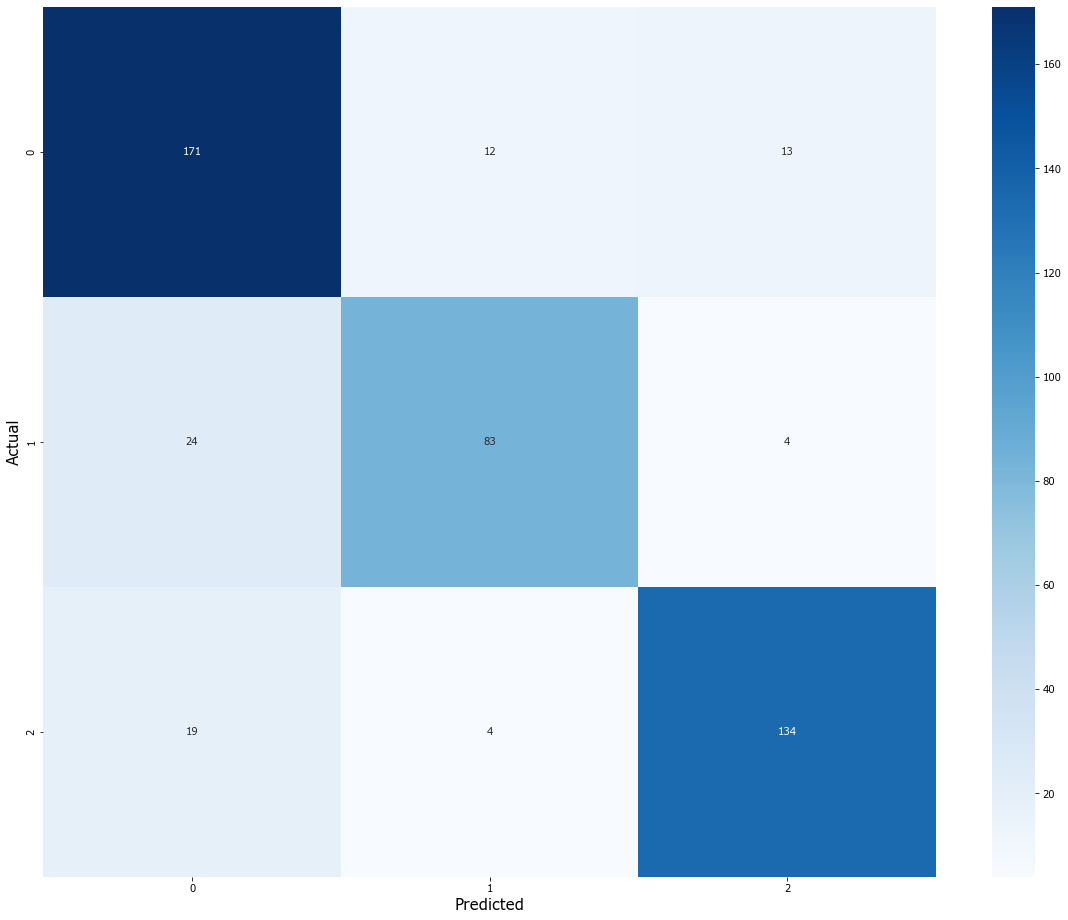

In [61]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
ypred = cnn_model.predict(X_test)
cnn_accuracy = accuracy_score(y_test.argmax(axis=-1),ypred.argmax(axis=-1))
print("CNN Accuracy:",cnn_accuracy)
cnn_cn = confusion_matrix(y_test.argmax(axis=-1),ypred.argmax(axis=-1))
plt.subplots(figsize=(20,16))
sns.heatmap(cnn_cn,annot=True,fmt="1d",cmap="Blues",cbar=True,xticklabels=classes,yticklabels=classes)
plt.xlabel("Predicted",fontsize=15)
plt.ylabel("Actual",fontsize=15)
# plt.savefig('model60_e40.png')
plt.show()

In [58]:
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=-1), ypred.argmax(axis=-1),target_names= classes))

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       196
           1       0.83      0.78      0.81       111
           2       0.89      0.87      0.88       157

    accuracy                           0.84       464
   macro avg       0.85      0.84      0.84       464
weighted avg       0.85      0.84      0.84       464



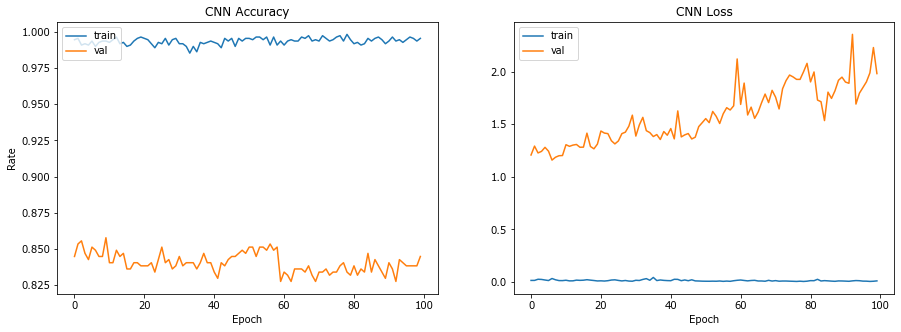

In [59]:
fig3, axe1 = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axe1[0].plot(cnn_history.history["accuracy"],label="accuracy")
axe1[0].plot(cnn_history.history["val_accuracy"],label="accuracy")
axe1[0].legend(['train', 'val'], loc='upper left')
axe1[1].plot(cnn_history.history["loss"],label="loss")
axe1[1].plot(cnn_history.history["val_loss"],label="loss")
axe1[1].legend(['train', 'val'], loc='upper left')
axe1[0].title.set_text("CNN Accuracy")
axe1[1].title.set_text("CNN Loss")
axe1[0].set_xlabel("Epoch")
axe1[1].set_xlabel("Epoch")
axe1[0].set_ylabel("Rate")
plt.show()